<a href="https://colab.research.google.com/github/helonayala/sysid/blob/main/recursive_least_squares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recursive Least Squares

Many real-world systems aren't static; their characteristics can change over time.

The **Recursive Least Squares (RLS)** method is a classic technique for estimating parameters in a linear-in-the-parameters model incrementally.

It finds the parameters that minimize the sum of the squared differences between the observed outputs and the outputs predicted by the model recursively, which is more suitable for real-time adaptive algorithms.

Instead of re-calculating the parameters from scratch every time new data arrives, as in batch least squares, RLS updates the parameter estimates incrementally.

The key advantage of RLS is its ability to **track changing parameters**. It achieves this by giving more weight to recent data and less weight to older data by manipulating the covariance matrix.


## Generate input/output data

We generate synthetic input/output data for a system with $n_a=n_b=2$. The parameters of this system are designed to change every 250 samples, creating a scenario to test the Recursive Least Squares (RLS) algorithm's ability to adapt and track these dynamic changes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1) # allows reproduction

# Number of measurements
N = 1250
t = np.arange(1, N + 1).reshape(-1, 1)
sig = 1e-2 # std of noise corrupting measurements

# Model parameters
a1 = -1.51 * np.ones((N, 1))
a2 = 0.55 * np.ones((N, 1))
b1 = 0.6 * np.ones((N, 1))
b2 = 0.16 * np.ones((N, 1))

# Add changes in the parameters
a1[250:] = 0.8 * a1[0]
a2[500:] = 1.2 * a2[0]
b1[750:] = 0.3 * b1[0]
b2[999:] = 2 * b2[0]



## Plot parameters

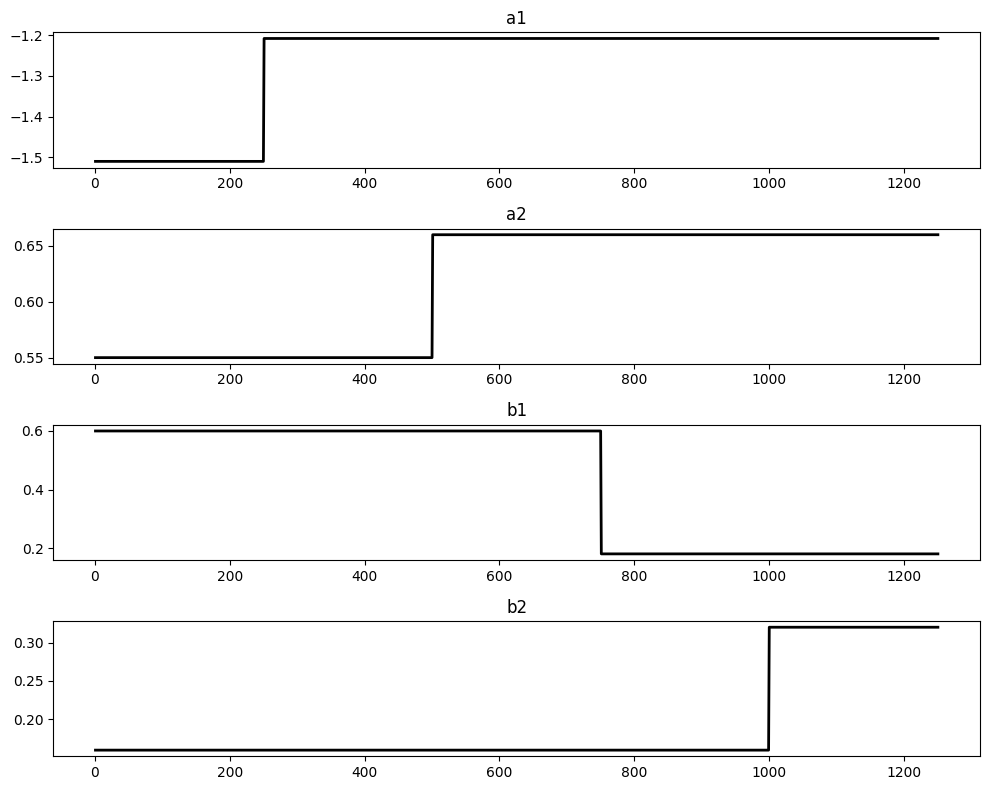

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(t, a1, '-k', linewidth=2)
plt.title('a1')
plt.subplot(412)
plt.plot(t, a2, '-k', linewidth=2)
plt.title('a2')
plt.subplot(413)
plt.plot(t, b1, '-k', linewidth=2)
plt.title('b1')
plt.subplot(414)
plt.plot(t, b2, '-k', linewidth=2)
plt.title('b2')
plt.tight_layout()
plt.show()


## Generate and plot input/output data


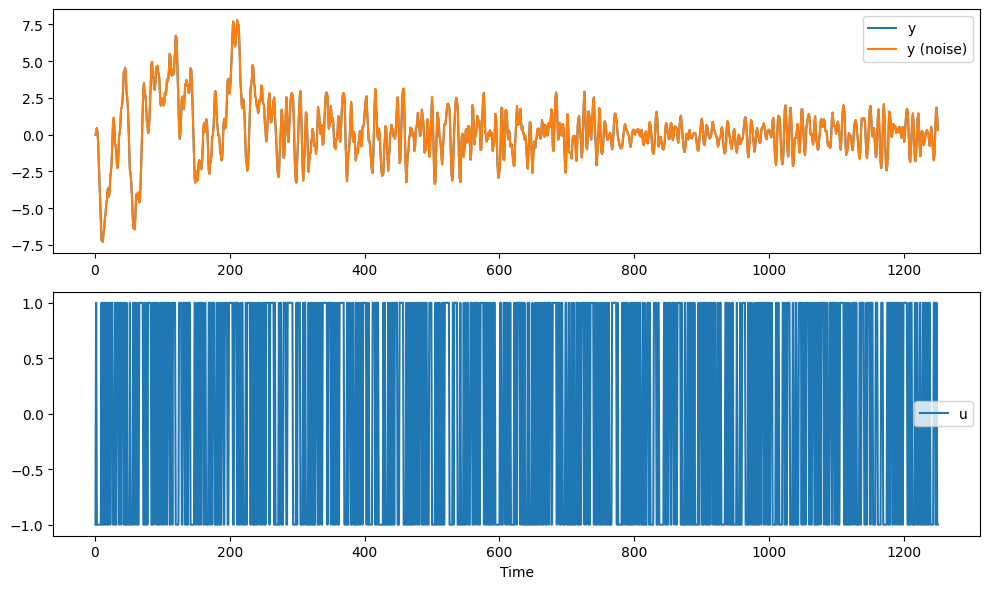

In [ ]:

# Init
yr = np.zeros((N, 1)) # model (no noise)
u = np.zeros((N, 1))
for i in range(N):
    if np.random.rand() > 0.5:
        u[i] = 1
    else:
        u[i] = -1

for k in range(2, N): # Python uses 0-based indexing, so start from 2 for k=3
    yr[k] = -a1[k] * yr[k-1] - a2[k] * yr[k-2] + b1[k] * u[k-1] + b2[k] * u[k-2]

y = yr + sig * np.random.randn(N, 1) # measurements (corrupted by noise)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, yr, label='y')
plt.plot(t, y, label='y (noise)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(t, u, label='u')
plt.legend()
plt.xlabel('Time')
plt.tight_layout()
plt.show()

## Perform RLS


In [ ]:
# Initialize parameters
P = 1e4 * np.eye(4) # P initial condition
th = np.zeros((4, 1)) # theta initial condition
lambda_val = 0.98 # forgetting factor
yh = np.zeros((N, 1)) # prediction
e = np.zeros((N, 1)) # prediction error

a1h = np.zeros((N, 1))
a2h = np.zeros((N, 1))
b1h = np.zeros((N, 1))
b2h = np.zeros((N, 1))

# strategy = 1 # RLS
# strategy = 2 # random walk
strategy = 3 # forgetting factor

for k in range(2, N): # Python uses 0-based indexing, so start from 2 for k=3
    # Step 2
    phi = np.array([[-y[k-1, 0]], [-y[k-2, 0]], [u[k-1, 0]], [u[k-2, 0]]]) # regression vector

    # Step 3
    yh[k] = phi.T @ th
    e[k] = y[k] - yh[k]

    # Step 4
    if strategy == 3: # forgetting factor
        K = P @ phi / (lambda_val + phi.T @ P @ phi)
    else:
        K = P @ phi / (1 + phi.T @ P @ phi)

    # Step 5
    th = th + K * e[k]

    # Step 6
    if strategy == 1: # RLS
        P = P - K @ (P @ phi).T
    elif strategy == 2: # random walk
        P = P - K @ (P @ phi).T
        p = len(th) + 1 # This line seems a bit off compared to typical RLS implementations for 'p'. Reverted to MATLAB's interpretation which just uses the length of th.
        q = np.trace(P) / len(th)
        Q = q * np.eye(P.shape[0])
        P = P + Q
    elif strategy == 3: # forgetting factor
        P = (1 / lambda_val) * (P - K @ (P @ phi).T)

    # Store estimated parameters for plotting
    a1h[k] = th[0]
    a2h[k] = th[1]
    b1h[k] = th[2]
    b2h[k] = th[3]


## Plot output: real vs estimated and residual

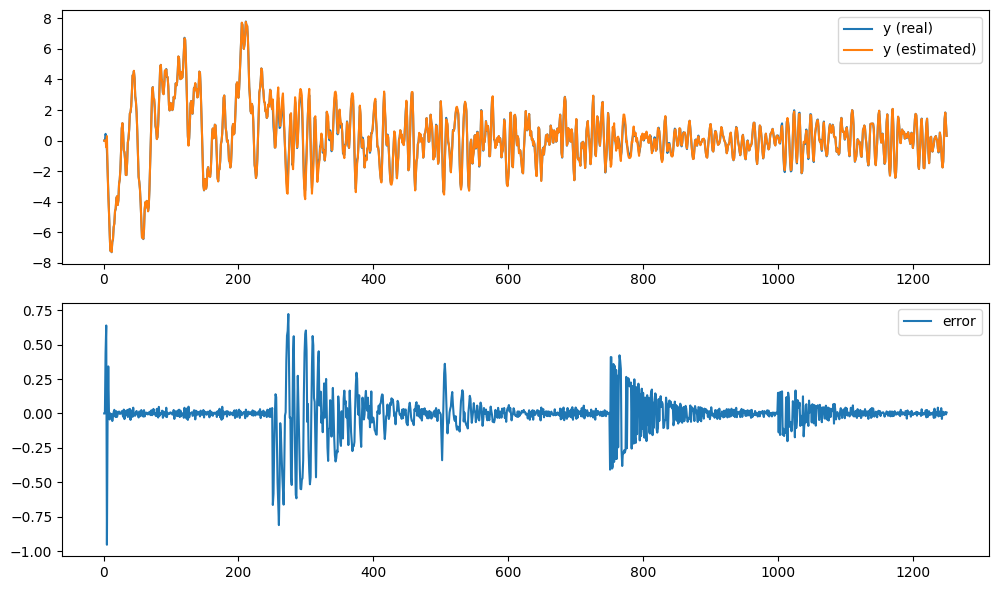

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, yr, label='y (real)')
plt.plot(t, yh, label='y (estimated)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(t, e, label='error')
plt.legend()
plt.tight_layout()
plt.show()


## Plot output: real vs estimated parameters


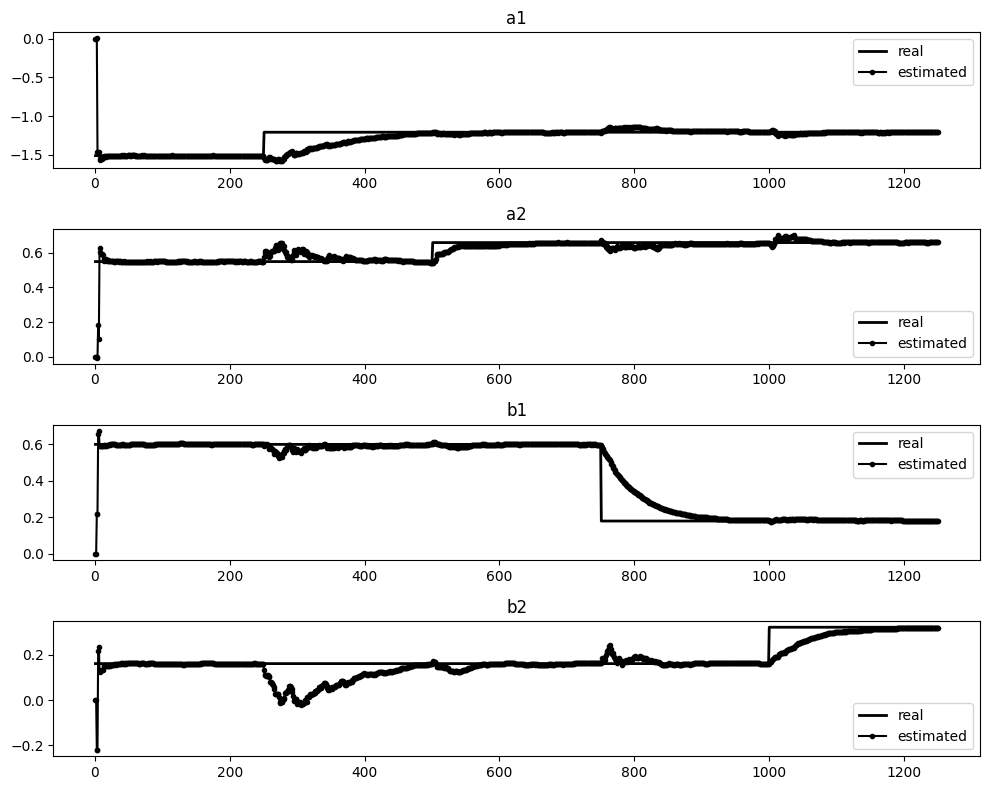

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(t, a1, '-k', linewidth=2, label='real')
plt.plot(t, a1h, '.-k', label='estimated')
plt.title('a1')
plt.legend()
plt.subplot(412)
plt.plot(t, a2, '-k', linewidth=2, label='real')
plt.plot(t, a2h, '.-k', label='estimated')
plt.title('a2')
plt.legend()
plt.subplot(413)
plt.plot(t, b1, '-k', linewidth=2, label='real')
plt.plot(t, b1h, '.-k', label='estimated')
plt.title('b1')
plt.legend()
plt.subplot(414)
plt.plot(t, b2, '-k', linewidth=2, label='real')
plt.plot(t, b2h, '.-k', label='estimated')
plt.title('b2')
plt.legend()
plt.tight_layout()
plt.show()